In [37]:
import os, csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
from sklearn.metrics import r2_score
from scipy.signal import find_peaks
from scipy.fftpack import fftfreq, fft

In [38]:
def get_data_from_path(path):
    # 读取文件内容
    with open(path, 'r', encoding='cp1252') as file:
        lines = file.readlines()

    # 创建字典来存储参数
    parameters = {}

    # 逐行读取文件内容
    for line in lines:
        # 去除行首尾的空白符
        line = line.strip()
        # 忽略空行和注释行
        if not line or line.startswith('#'):
            continue
        # 如果行包含等号，则将其解析为键值对
        if '=' in line:
            key, value = line.split('=')
            parameters[key.strip()] = value.strip()

        # 读取数据表格
    data_start = False
    # data = []
    times, hfs, amps = [], [], []

    for line in lines:
        if line.startswith("Depth ["):
            data_start = True
            continue
        if data_start and line.strip():
            # data.append(line.strip().split())
            time, hf, amp = line.strip().split()
            times.append(float(time))
            hfs.append(float(hf))
            amps.append(float(amp))

    times = np.array(times)
    hfs = np.array(hfs)
    amps= np.array(amps)

    return times, hfs, amps



# resolution power

嘗試把你寫code判斷過程寫出來？大概可以寫在caption裡？

resolution power threshold? 像是光學那樣？ 多少頻率會是可分辨的？

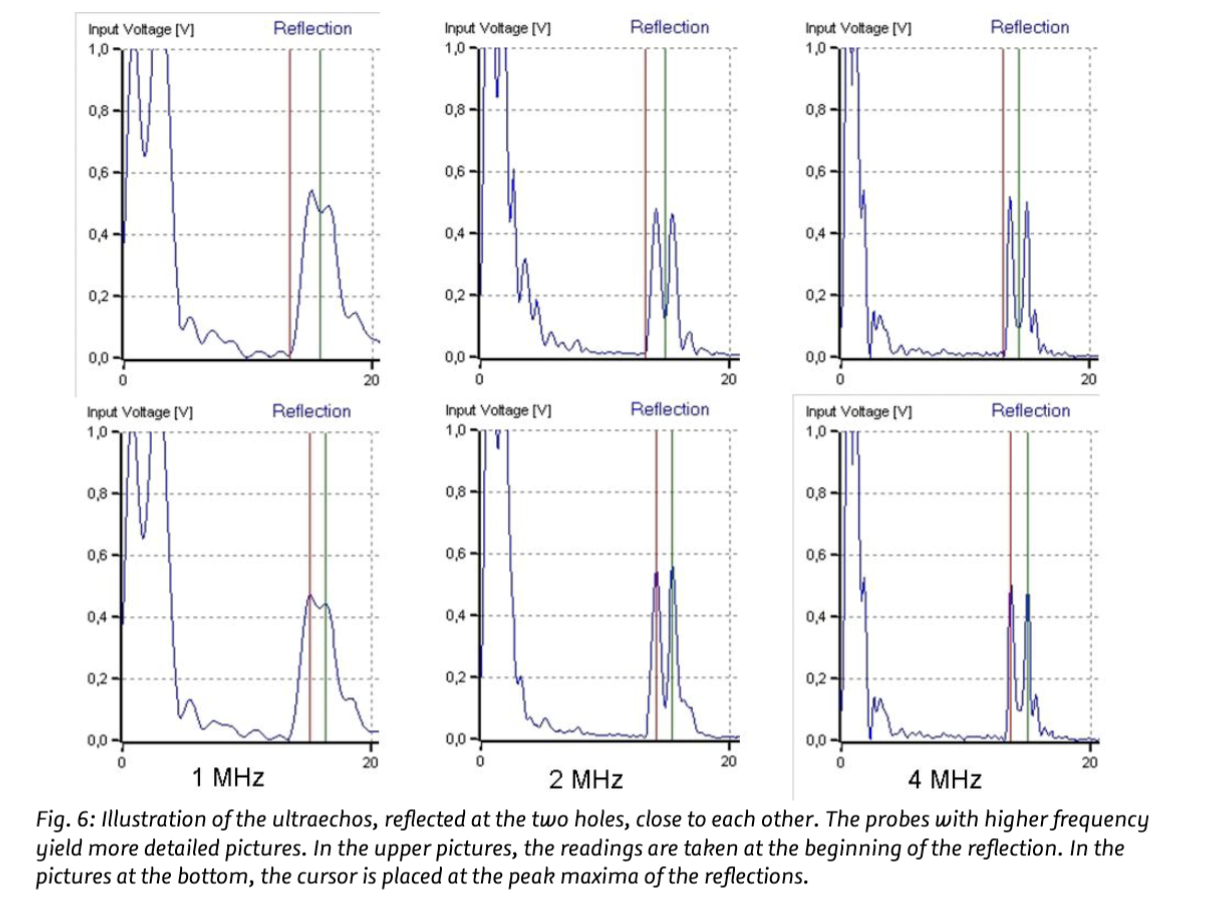

# dimensions of the bulk

dim1: 1,2,4 measured 

dim2: 1,2,4

dim3: 1,2 (4 is unable to detect the echo)

PHY06: 80.46, 150.44, 42.00

In [39]:
def find_start_peak_between(times, amps, range):
    mask = np.where((times>range[0])&(times<range[1])&(amps > 0.05))
    return np.min(times[mask]), times[mask][np.argmax(amps[mask])]

def avg(array):
    n = np.average(array)
    err = np.std(array)/np.sqrt(len(array)-1)
    return(ufloat(n,err))

def get_freq_between(times, hfs, range, plot=False):
    mask = np.where((times>range[0])&(times<range[1]))
    x = times[mask]
    y = hfs[mask]
    xf = fftfreq(len(x), np.average(np.diff(x)))
    yf = fft(y)
    fft_mask = np.where((xf>0)&(xf<5))
    xf=xf[fft_mask]
    yf=np.abs(yf[fft_mask])
    if plot:
        plt.plot(xf, yf)
    return xf[np.argmax(yf)]

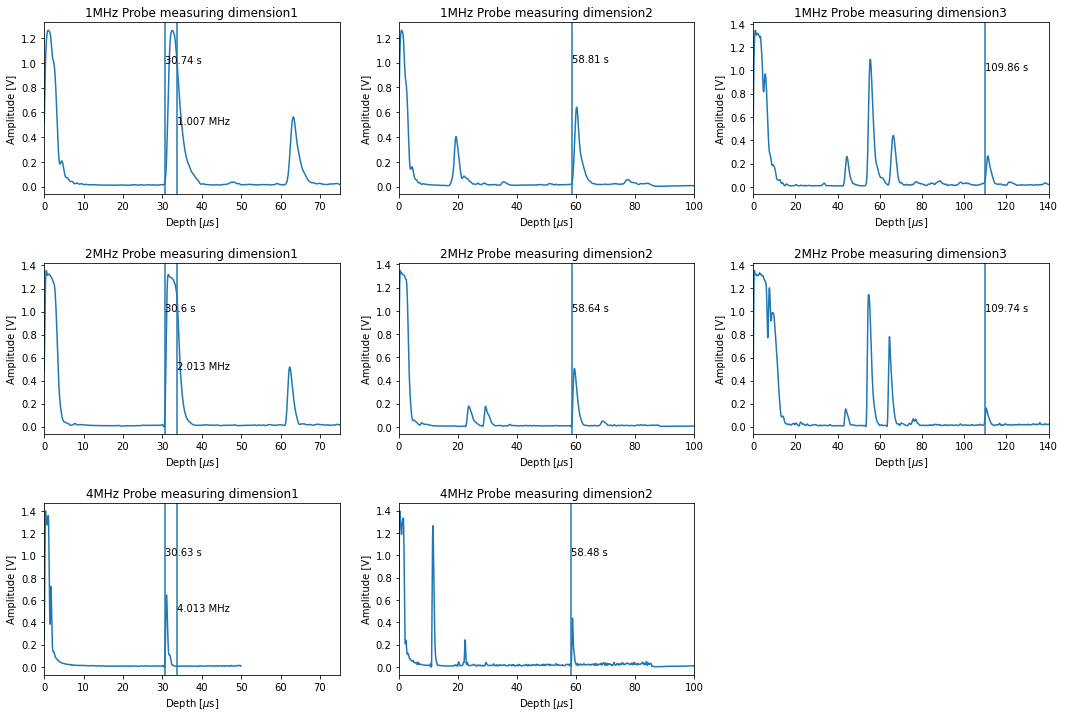

In [40]:

dims = np.array([1,2,3])

#  3i+j+1       freq 0  freq 1  freq2
# dim 0    1 2 3
# dim 1    4 5 6
# dim 2    7 8 9

starts = np.zeros((3,3))

ranges = [(20,40),(50,70),(100,120)]

plot_ranges = [(0,75),(0,100),(0,140)]

plt.figure(figsize=(18,12))

for i in range(3):
    dim  = dims[i]
    r = ranges[i]
    pr = plot_ranges[i]
    for j in range(3):
        if (i == 2) and (j == 2): 
            continue
        else:
            freq = freqs[j]
            times, hfs, amps = get_data_from_path(os.getcwd()+f'/dimensions/{freq}MHz_dim{dim}.dat')
            
            start, peak = find_start_peak_between(times, amps, r)
            
            plt.subplot(int(f'33{i+3*j+1}'))
            plt.subplots_adjust(hspace=0.4)
            plt.xlim(pr[0],pr[1])
            starts[i,j] = start
            plt.axvline(start)
            plt.text(start,1,f'{start} s')
            plt.plot(times, amps)
            plt.title(f'{freq}MHz Probe measuring dimension{dim}')
            # plt parameters for ascan plt
            plt.xlabel(r'Depth [$\mu$s]')
            plt.ylabel(r'Amplitude [V]')

            if dim == 1:
                peak = start + 3
                plt.axvline(peak)
                freq = get_freq_between(times, hfs, (start,peak))
                plt.text(peak, 0.5, f'{freq:.3f} MHz')

plt.savefig('PHY06_dimensions.png')

In [41]:
x1, x2, x3 = ufloat(42.00,0.01), ufloat(80.46,0.01), ufloat(150.44,0.01)

print(x1)
print(x2)
print(x3)

print(t1:=avg(starts[0,:]))
print(t2:=avg(starts[1,:]))
print(t3:=avg(starts[2,0:2]))

print(c_1:=2e3*x1/t1, c_2:=2e3*x2/t2, c_3:=2e3*x3/t3)

print(c:=(c_1+c_2+c_3)/3)

42.000+/-0.010
80.460+/-0.010
150.440+/-0.010
30.66+/-0.04
58.64+/-0.10
109.80+/-0.06
2740+/-4 2744+/-4 2740.3+/-1.5
2741.4+/-2.0


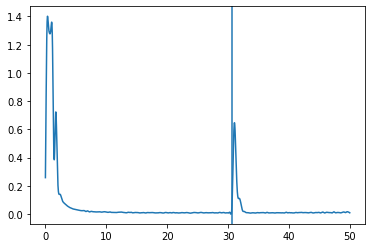

In [42]:
times, hfs, amps = get_data_from_path(os.getcwd()+f'/dimensions/4MHz_dim1.dat')
start,_ = find_start_peak_between(times, amps, (20,40))
plt.axvline(start)
plt.plot(times, amps)

# Pulse width of echo hole

pulse width 對 f 的理論值？

rename:
2-1  1
2-2  two hole
2-3  8
2-4  7
2-5  6
2-6  5
2-7  4
2-8  3
2-9  2

In [43]:
import os

def get_dat_paths(root_dir_relative):
    current_dir = os.getcwd()
    root_dir = os.path.abspath(os.path.join(current_dir, root_dir_relative))

    dat_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.dat'):
                dat_paths.append(os.path.join(dirpath, filename))
    return dat_paths

paths = get_dat_paths('pulse_width/1MHz')
paths = np.sort(paths)[2:]

N=len(paths)

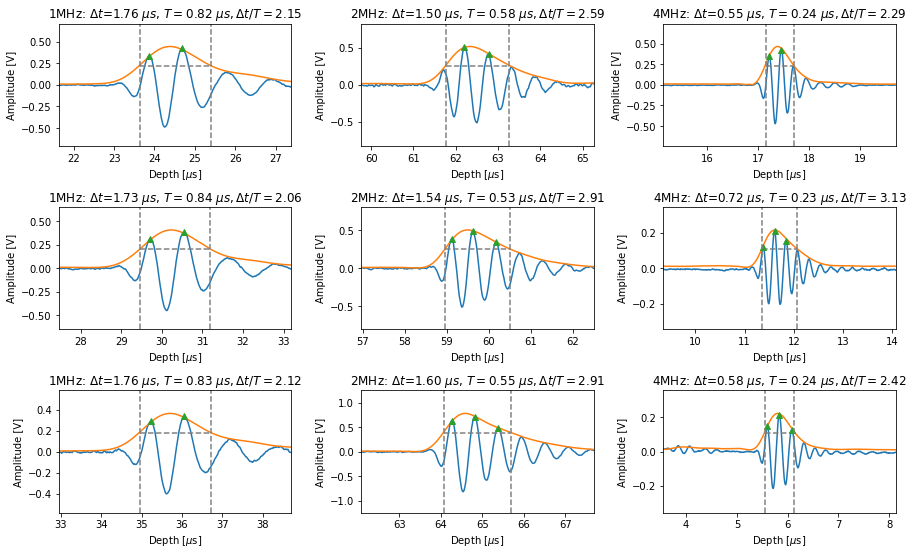

In [44]:
plt.figure(figsize=(15,3*N))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i,path in enumerate(paths):
    times, hfs, amps = get_data_from_path(path)
    plt.subplot(int(f'33{3*i+1}'))
    plt.plot(times, hfs)
    plt.plot(times, amps)
    
    filename = path.split('/')[-1].removesuffix('.dat')

    if filename == '4MHz_hole1':
        xlim = (5,20)
    else:
        xlim = (10,40)
    mask = np.where((times > xlim[0])&(times < xlim[1]))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    max = np.max(amps)
    over_half = np.where(amps - max / 2 > 0)
    plt.plot(t:=times[over_half], max / 2 * np.ones_like(t), linestyle='--', color = 'grey')
    half_start = np.min(t)
    half_end = np.max(t)

    y = hfs[over_half]
    peaks,_ = find_peaks(y,height=0, distance=10)
    plt.plot(t[peaks],y[peaks],'^')

    period = np.average(np.diff(t[peaks]))

    plt.axvline(half_start, linestyle='--', color = 'grey')
    plt.axvline(half_end, linestyle='--', color = 'grey')

    width = half_end - half_start

    plt.title(rf'1MHz: $\Delta t$={width:.2f} $\mu s$, $T=${period:.2f} $\mu s, \Delta t/T=${width/period:.2f}')

    plt.xlim(half_start -2, half_end + 2)
    plt.ylim(-1.6*max, 1.6*max)

    # plt parameters for ascan plt
    plt.xlabel(r'Depth [$\mu$s]')
    plt.ylabel(r'Amplitude [V]')
    # end

paths = get_dat_paths('pulse_width/4MHz')
N=len(paths)

for i,path in enumerate(paths):
    times, hfs, amps = get_data_from_path(path)
    plt.subplot(int(f'33{3*i+3}'))
    plt.plot(times, hfs)
    plt.plot(times, amps)
    
    filename = path.split('/')[-1].removesuffix('.dat')

    if filename == '4MHz_hole1':
        xlim = (5,20)
    else:
        xlim = (10,40)
    mask = np.where((times > xlim[0])&(times < xlim[1]))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    max = np.max(amps)
    over_half = np.where(amps - max / 2 > 0)
    plt.plot(t:=times[over_half], max / 2 * np.ones_like(t), linestyle='--', color = 'grey')
    half_start = np.min(t)
    half_end = np.max(t)

    y = hfs[over_half]
    peaks,_ = find_peaks(y,height=0)
    plt.plot(t[peaks],y[peaks],'^')
    period = np.average(np.diff(t[peaks]))
    
    plt.axvline(half_start, linestyle='--', color = 'grey')
    plt.axvline(half_end, linestyle='--', color = 'grey')

    width = half_end - half_start

    plt.title(rf'4MHz: $\Delta t$={width:.2f} $\mu s$, $T=${period:.2f} $\mu s, \Delta t/T=${width/period:.2f}')

    plt.xlim(half_start -2, half_end + 2)
    plt.ylim(-1.6*max, 1.6*max)

    # plt parameters for ascan plt
    plt.xlabel(r'Depth [$\mu$s]')
    plt.ylabel(r'Amplitude [V]')
    # end

for i in range(3):
    dim  = dims[i]
    times, hfs, amps = get_data_from_path(os.getcwd()+f'/dimensions/2MHz_dim{dim}.dat')
    plt.subplot(int(f'33{3*i+2}'))
    plt.plot(times, hfs)
    plt.plot(times, amps)
    plt.xlim(50,70)

    xlim = (50,70)
    if dim ==3:
        xlim = (60,70)
    mask = np.where((times > xlim[0])&(times < xlim[1]))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    max = np.max(amps)
    over_half = np.where(amps - max / 2 > 0)
    plt.plot(t:=times[over_half], max / 2 * np.ones_like(t), linestyle='--', color = 'grey')
    half_start = np.min(t)
    half_end = np.max(t)

    y = hfs[over_half]
    peaks,_ = find_peaks(y,height=0)
    plt.plot(t[peaks],y[peaks],'^')
    period = np.average(np.diff(t[peaks]))

    plt.axvline(half_start, linestyle='--', color = 'grey')
    plt.axvline(half_end, linestyle='--', color = 'grey')

    width = half_end - half_start

    plt.title(rf'2MHz: $\Delta t$={width:.2f} $\mu s$, $T=${period:.2f} $\mu s, \Delta t/T=${width/period:.2f}')

    plt.xlim(half_start -2, half_end + 2)
    plt.ylim(-1.6*max, 1.6*max)

    # plt parameters for ascan plt
    plt.xlabel(r'Depth [$\mu$s]')
    plt.ylabel(r'Amplitude [V]')
    # end

plt.savefig('PHY06_pulse_width.png')

In [45]:
pw1 = avg([1.73,1.73,1.76])
pw2 = avg([1.50,1.54,1.60])
pw3 = avg([0.55, 0.72, 0.58])

peak times diff time distance [1.31]
peak times diff distance 1.7956+/-0.0013
start times diff time distance [1.82]
start times diff distance 2.4947+/-0.0018
peak times diff time distance [1.24]
peak times diff distance 1.6997+/-0.0013
start times diff time distance [1.24]
start times diff distance 1.6997+/-0.0013


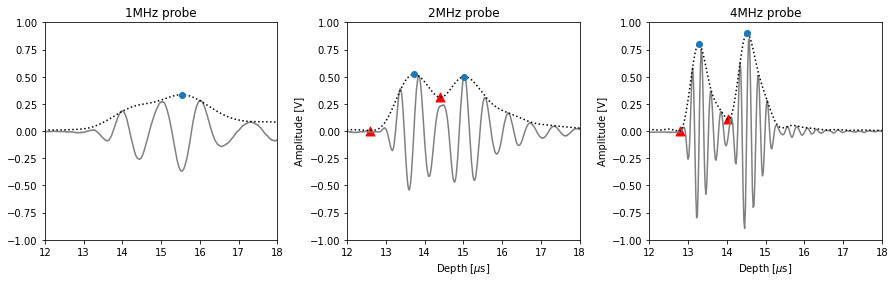

In [47]:
freqs = np.array([1,2,4])

plt.figure(figsize=(15, 4))
plt.subplots_adjust(wspace=0.3)

for i, freq in enumerate(freqs):
    plt.subplot(int(f'13{i+1}'))
    times, hfs, amps = get_data_from_path(os.getcwd()+f'/resolution/{freq}MHz.dat')

    mask = np.where((times<20)&(times>0))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    dt = np.average(np.diff(times))


    plt.title(f'{freq}MHz probe')
    plt.plot(times, hfs, color='grey')
    plt.plot(times, amps, color='black', ls='dotted')
    plt.xlim(12,18)
    plt.ylim(-1,1)

    peaks, _ = find_peaks(amps, distance = 1/dt, height = 0.25)

    peaks = peaks[np.where(times[peaks]>12.5)]

    plt.plot(peak_times:=times[peaks], amps[peaks], 'o')

    if freq != 1:
        print('peak times diff time distance',np.diff(peak_times))
        print('peak times diff distance',np.diff(peak_times)[0]*1e-6 * c / 2 * 1e3)


        before_peaks = np.where((times < peak_times[0]) & (times > peak_times[0]-5))
        start = times[before_peaks][np.argmin(amps[before_peaks])]

        between_peaks = np.where((np.arange(0,len(times))>peaks[0] ) & ( np.arange(0,len(times))<peaks[1]))
        argmin, min = times[between_peaks][np.argmin(amps[between_peaks])], np.min(amps[between_peaks])
        plt.scatter(start_times := [start, argmin], [0,min], marker='^', color = 'red', s= 80)

        print('start times diff time distance', np.diff(start_times))
        print('start times diff distance', np.diff(start_times)[0]*1e-6 * c / 2 * 1e3)

        plt.xlabel(r'Depth [$\mu$s]')
        plt.ylabel(r'Amplitude [V]')

plt.savefig('PHY06_resolution.png')